In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/gggsdsd/balanced.csv',encoding='utf-8')
df.head()

,texts,label
0,अमेरिकी और रूसी पुलिस के संयुक्त अभियान के फलस...,0
1,आज यहां रांची एक्सप्रेस के साथ बातचीत में वित्...,0
2,हमे इन्तजार है ।,1
3,जिस के नतीजे मे ये हुक्म सादिर किया गया है ।,1
4,जयपुर,0


In [ ]:
df = df[df['texts'].apply(lambda x: isinstance(x, str))]

Summary of Features

    TTR (Type-Token Ratio)
    Root TTR
    Log TTR
    Maas TTR
    MSTTR (Mean Segmental TTR)
    MATTR (Moving Average TTR)
    HDD (Herdan's D)
    MTLD (Measure of Textual Lexical Diversity)
    MTLD MA
    MTLD MA Bi
    VocD (Vocabulary Density)
    YulesK

In [ ]:
import pandas as pd
import random
import collections
import numpy as np
from scipy.optimize import curve_fit
import math
from indicnlp.tokenize import indic_tokenize

class LexicalDiversity:
    def __init__(self, text):
        self.text = text
        # Use Indic NLP tokenizer for Hindi
        self.tokens = indic_tokenize.trivial_tokenize(self.text)

    def lexical_diversity(self):
        ttr = self.ttr(self.tokens)
        root_ttr = self.root_ttr(self.tokens)
        log_ttr = self.log_ttr(self.tokens)
        maas_ttr = self.maas_ttr(self.tokens)
        mtld = self.mtld(self.tokens)

        # VOC-D measure
        D_init = 0
        for _ in range(3):
            D_init = D_init + self.vocd(self.tokens)
        D = D_init / 3

        yulesK = self.get_yules(self.tokens)

        return {
            "TTR": ttr,
            "Root TTR": root_ttr,
            "Log TTR": log_ttr,
            "Maas TTR": maas_ttr,
            "MTLD": mtld,
            "VocD": D,
            "YulesK": yulesK,
        }

    def ttr(self, tokens):
        return len(set(tokens)) / len(tokens) if tokens else 0

    def root_ttr(self, tokens):
        return len(set(tokens)) / math.sqrt(len(tokens)) if tokens else 0

    def log_ttr(self, tokens):
        return math.log(len(set(tokens))) / math.log(len(tokens)) if tokens and len(tokens) > 1 else 0

    def maas_ttr(self, tokens):
        return (math.log(len(tokens)) - math.log(len(set(tokens)))) / math.log(len(tokens)) ** 2 if tokens and len(tokens) > 1 else 0

    def mtld(self, tokens, factor_size=0.72):
        def factor_count(tokens, ttr):
            factors = 0
            factor_len = 0
            types = set()
            for token in tokens:
                factor_len += 1
                types.add(token)
                if len(types) / factor_len <= ttr:
                    factors += 1
                    factor_len = 0
                    types = set()
            return factors + (factor_len / len(tokens))

        if len(tokens) < 2:
            return 0
        forward = factor_count(tokens, factor_size)
        backward = factor_count(tokens[::-1], factor_size)
        return len(tokens) / ((forward + backward) / 2)

    def vocd(self, tokens):
        try:
            average_ttr = []
            for sample in range(35, 51):
                ttr_ = []
                for _ in range(100):
                    sampleTokens = random.sample(tokens, min(sample, len(tokens)))
                    tt = self.ttr(sampleTokens)
                    ttr_.append(tt)
                avg = np.mean(ttr_)
                average_ttr.append(avg)
            N = [x for x in range(35, 51)]
            popt, _ = curve_fit(self.func, N, average_ttr)
            return popt[0]
        except:
            return 0

    def func(self, n, d):
        ttrr = (d / n) * (np.sqrt(1 + 2 * (n / d)) - 1)
        return ttrr

    def get_yules(self, tokens):
        if len(tokens) < 2:
            return 0
        token_counter = collections.Counter(tok for tok in tokens)
        m1 = sum(token_counter.values())
        m2 = sum([freq**2 for freq in token_counter.values()])
        if m2 == m1:
            return 0  # All tokens are unique
        i = (m1 * m1) / (m2 - m1)
        k = 1 / i * 10000
        return k

def calculate_features(text):
    ld_obj = LexicalDiversity(text)
    return ld_obj.lexical_diversity()


# Apply the function to each text in the DataFrame
features_df = df['texts'].apply(calculate_features).apply(pd.Series)

# Concatenate the new features with the original DataFrame
df = pd.concat([df, features_df], axis=1)
df.head()

# Save the updated DataFrame
df.to_csv('lexical_features.csv', index=False)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Separate features and target
X = df.drop('label', axis=1)
X = X.drop('texts', axis=1)
y = df['label']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)
y_pred_logistic = logistic_regression.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("\nLogistic Regression Accuracy:", accuracy_logistic)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.6770483329025588

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      3826
           1       0.70      0.63      0.66      3912

    accuracy                           0.68      7738
   macro avg       0.68      0.68      0.68      7738
weighted avg       0.68      0.68      0.68      7738



Feature Importance:
 Root TTR    1.352527
TTR         1.059537
MTLD        0.556072
Maas TTR    0.528135
YulesK      0.491670
VocD        0.218089
Log TTR     0.016326
dtype: float64


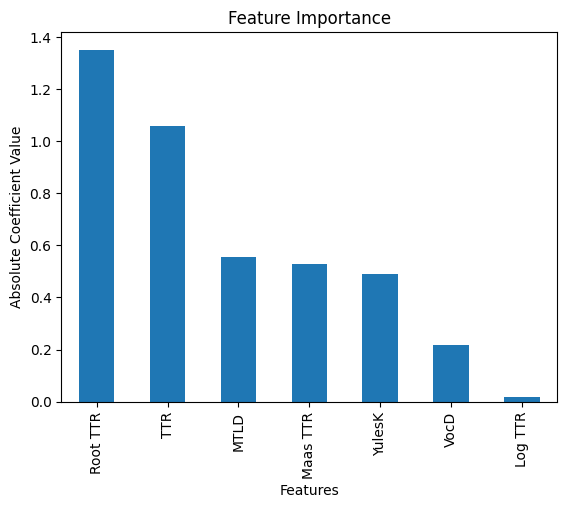

In [ ]:
coefficients = logistic_regression.coef_[0]
feature_importance = pd.Series(coefficients, index=X.columns)

# Get the absolute values of the coefficients to determine importance
feature_importance = np.abs(feature_importance)
feature_importance = feature_importance.sort_values(ascending=False)

print("Feature Importance:\n", feature_importance)

# Optionally, visualize the feature importance
import matplotlib.pyplot as plt
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.show()